## WORKFLOW --- EXPORT ALL POLYGONS

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# to work with rasters
# https://rasterio.readthedocs.io/en/latest/quickstart.html#opening-a-dataset-in-reading-mode
import rasterio
from rasterio.plot import show
from rasterio.features import shapes

from shapely.geometry import Polygon
from shapely.affinity  import affine_transform
import geopandas as gpd

In [2]:
### ***** FUNCTIONS TO THICKEN PIXELS *****

# ------------------------------------------------------------------

def thicken_pixel(raster, i_cent,j_cent, d):
    
    i_0 = int(i_cent - ((d-1)/2))
    j_0 = int(j_cent - ((d-1)/2))

    for x in range(i_0,i_0+d):
        for y in range(j_0,j_0+d):
            if(-1<x<raster.shape[0] and -1<y<raster.shape[1]):
                if(raster[x,y] != 1):
                    raster[x,y] = 1
    return 
# ------------------------------------------------------------------

def thicken_pixels(raster,d):
    m = raster.shape[0]
    n = raster.shape[1]
    
    new_rast = np.zeros((m,n))
    
    for i in range(0,m):
        for j in range(0,n):
            if(raster[i,j] == 1):
                thicken_pixel(new_rast,i,j,d)
                
    return new_rast

In [3]:
# *** EXTRACT POLYGONS FROM REGIONS ***

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from the rasterio.features.shapes function
# rasterio.features.shapes returns a list of pairs (shape, value), example of a pair:
#   ({'type': 'Polygon', 'coordinates': [[(6,0),(6,2),(8,0),(6,0)]]}, 1.0)
#   shape is the first entry (the dictionary)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return(Polygon(poly_list[0]))

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------

# shapes list is the output from rasterio.features.shapes 
# crs will be assigned to the GeoDataFrame
def shapes_2_GeoDataFrame(shapes_list, crs = False):

    df = gpd.GeoDataFrame() 
    i = 0
    for shape, value in shapes_list:
        df.loc[i,'geometry'] =create_polygon(shape)
        i = i+1

    if(crs != False):
        df.crs = crs
    
    return df
    

## EXMAPLE

In [4]:
arid8 = rasterio.open('arid_regions_2008.tif')
arid19 = rasterio.open('arid_regions_2019.tif')
#show(arid8)
#show(arid19)

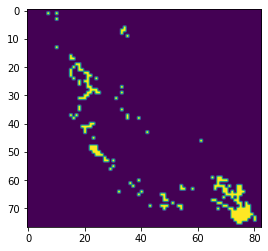

<AxesSubplot:>

In [5]:
# desert = 1
# dry = 2
# moist = 3

more_arid = arid8.read(1) -  arid19.read(1)
more_arid = np.where(more_arid<1,0,more_arid) 
more_arid = np.where(more_arid>0,1,more_arid)
show(more_arid)

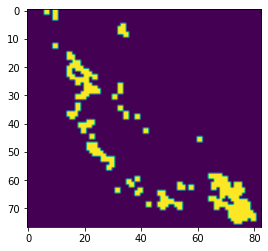

<AxesSubplot:>

In [6]:
thick_regions = thicken_pixels(more_arid,2)
# shapes function only takes certain types (see documentation)
# since raster is binary, we're using the smalest type uint8
thick_regions = thick_regions.astype('uint8')  
show(thick_regions)

In [8]:
# shapes_list is type generator: iterable once
thick_shps = shapes(source = thick_regions, 
                     mask= thick_regions,   # include this so regions with value 0 are not inclduded
                     connectivity = 8,
                     transform = arid8.transform)

aff_data = shapes_2_GeoDataFrame(thick_shps , arid8.crs)
aff_data

,geometry
0,"POLYGON ((-123.75057 42.12519, -123.75057 41.8..."
1,"POLYGON ((-123.37556 42.12519, -123.37556 41.6..."
2,"POLYGON ((-120.37555 41.50019, -120.12555 41.5..."
3,"POLYGON ((-123.37556 40.62519, -123.37556 40.3..."
4,"POLYGON ((-122.75056 40.25018, -122.50056 40.2..."
5,"POLYGON ((-120.50055 38.87518, -120.25055 38.8..."
6,"POLYGON ((-120.50055 37.87517, -120.50055 37.6..."
7,"POLYGON ((-122.37556 38.00017, -122.12556 38.0..."
8,"POLYGON ((-119.75055 37.50017, -119.75055 37.2..."
9,"POLYGON ((-121.87556 37.25017, -121.50056 37.2..."


In [12]:
# Create an output path for the data
outfp = "/home/jovyan/outlining_regions/trial_polygons2.shp"
aff_data.to_file(outfp)